In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from diffusers import UNet2DConditionModel, DDPMScheduler
import torch
from torch.optim import AdamW
from common.dataset import ADNIDatasetSlicesInOrder
from torch.utils.data import DataLoader
from common.utils import load_trained_model, load_trained_embedder, plot_batch_slices, normalise_intensity_per_slice
import numpy as np
import matplotlib.pyplot as plt
from common.sample import sample_next_slices, sample_iteratively, get_index_encoding

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
batch_size = 4

In [4]:
out_dir = "/cim/ehoney/ecse626proj/experiments/experiment14"

In [5]:
data_size = 64
slices_at_once=4
num_train_timesteps=1000
symmetric_normalisation = False
if symmetric_normalisation:
    vmin=-1
else:
    vmin=0

In [6]:
model = UNet2DConditionModel(
    sample_size=data_size,
    in_channels=2*slices_at_once, #16
    out_channels=slices_at_once, #8 #initialise to maximum and compute loss only for indexed slices
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D", "CrossAttnDownBlock2D"),
    mid_block_type=None,
    up_block_types=("CrossAttnUpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D"),
    # not sure about what the lower arguments do
    block_out_channels=(256, 256, 512, 512, 1024, 1024), #start with 64? no deeper than 1024
    layers_per_block=2, #default
    cross_attention_dim=1, # ~concat one-hot encodings of condition and target slices~ NO now instead just one 128 vector with labels 0,1,2
    attention_head_dim=8, #default
    norm_num_groups=32, #default
    use_linear_projection=True #DIFFERENT
)
print(f"Model initialised. Number of model parameters: {model.num_parameters()}.")
model.to(device)

Model initialised. Number of model parameters: 494387716.


UNet2DConditionModel(
  (conv_in): Conv2d(8, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=256, out_features=1024, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 256, eps=1e-05, affine=True)
          (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=1024, out_features=256, bias=True)
          (norm2): GroupNorm(32, 256, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
        

In [7]:
noise_scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps)

In [8]:
epoch = load_trained_model(model, os.path.join(out_dir,'latest_ckpt.pth.tar'))

/cim/ehoney/ecse626proj/common/utils.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path)


Checkpoint loaded from epoch 1500.


In [11]:
# noised_target_slices = torch.randn(batch_size, slices_at_once, data_size, data_size, device=device)

In [12]:
# condition_slices = torch.zeros_like(noised_target_slices)

In [13]:
# first_target_slice_indices = torch.zeros(4, dtype=torch.int).to(device)

In [14]:
# encoder_hidden_states = get_index_encoding('index_normalised', first_target_slice_indices, slices_at_once, None, data_size=data_size)

In [15]:
# target_slices = sample_next_slices(noised_target_slices, condition_slices, model, noise_scheduler, batch_size, device, encoder_hidden_states, verbose=True)

In [16]:
# plot_batch_slices(target_slices, batch_size, slices=slices_at_once, vmin=vmin)

In [17]:
# data_dir = "/cim/ehoney/ecse626proj/preprocessed_data_64"
# train_dataset = ADNIDatasetSlicesInOrder(data_dir, sample_full_brain=True, symmetric_normalisation=symmetric_normalisation, data_size=data_size)
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8) # CHANGE to NUM_WORKERS=4

In [21]:
# one_batch = next(iter(train_dataloader))
one_batch=None

In [22]:
condition_start_index = None

In [ ]:
save_plots_dir = os.path.join(out_dir,f'{{epoch={epoch}}}_{{cond={condition_start_index}}}')
os.makedirs(save_plots_dir, exist_ok=True)

Sampling slices 0 to 4...
Generated slices in range [(tensor(-0.1104, device='cuda:0'), tensor(1., device='cuda:0'))]


/cim/ehoney/ecse626proj/common/utils.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar


Complete.
Sampling slices 4 to 8...
Generated slices in range [(tensor(-0.1098, device='cuda:0'), tensor(1., device='cuda:0'))]
Complete.
Sampling slices 8 to 12...
Generated slices in range [(tensor(-0.1594, device='cuda:0'), tensor(1., device='cuda:0'))]
Complete.
Sampling slices 12 to 16...
Generated slices in range [(tensor(-0.1512, device='cuda:0'), tensor(1., device='cuda:0'))]
Complete.
Sampling slices 16 to 20...
Generated slices in range [(tensor(-0.1417, device='cuda:0'), tensor(1., device='cuda:0'))]
Complete.
Sampling slices 20 to 24...
Generated slices in range [(tensor(-0.1618, device='cuda:0'), tensor(1., device='cuda:0'))]
Complete.
Sampling slices 24 to 28...
Generated slices in range [(tensor(-0.0808, device='cuda:0'), tensor(1., device='cuda:0'))]
Complete.
Sampling slices 28 to 32...
Generated slices in range [(tensor(-0.0893, device='cuda:0'), tensor(1., device='cuda:0'))]
Complete.
Sampling slices 32 to 36...
Generated slices in range [(tensor(-0.0575, device='cud

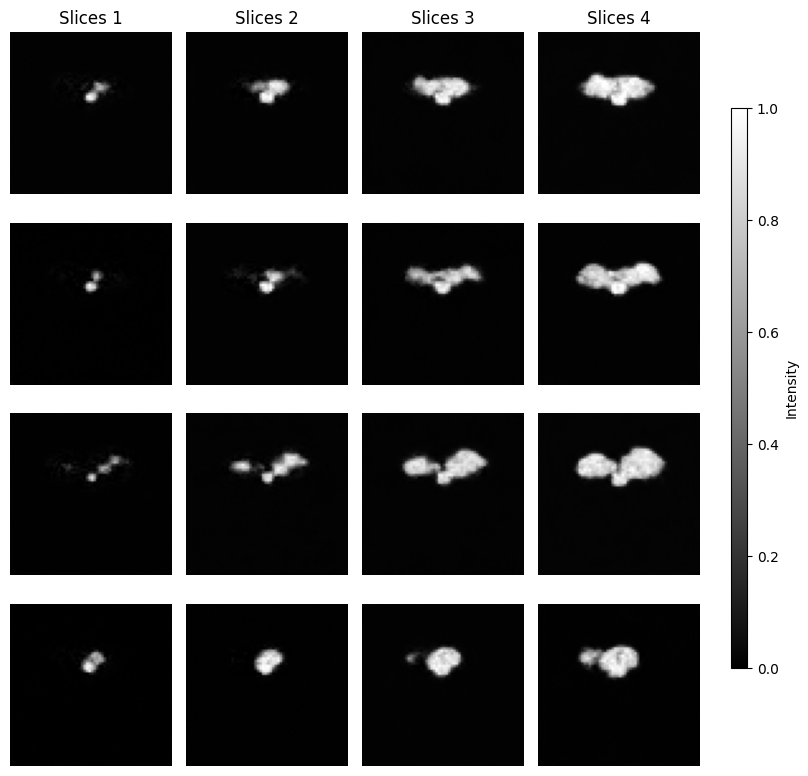

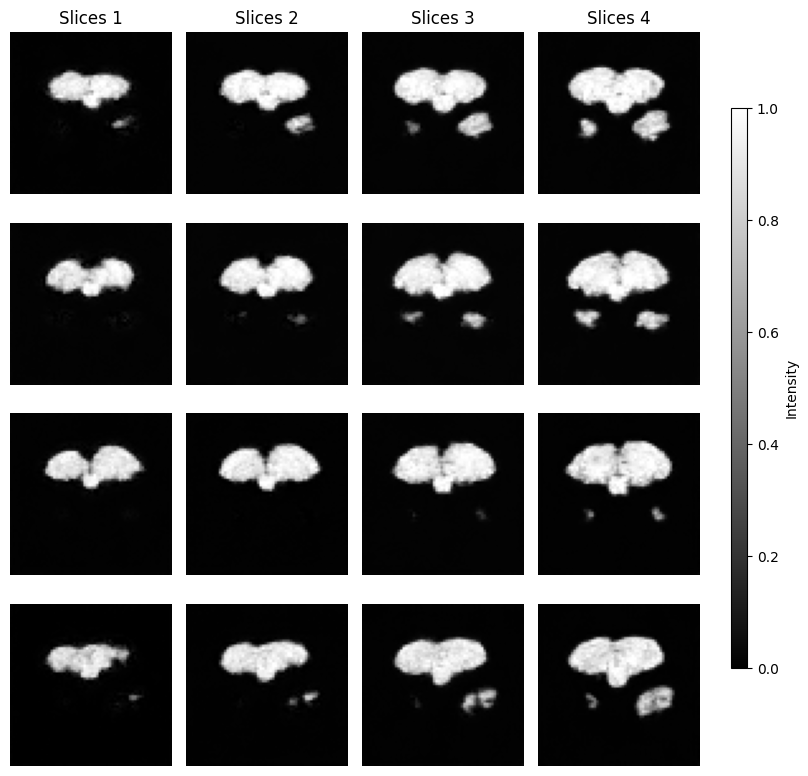

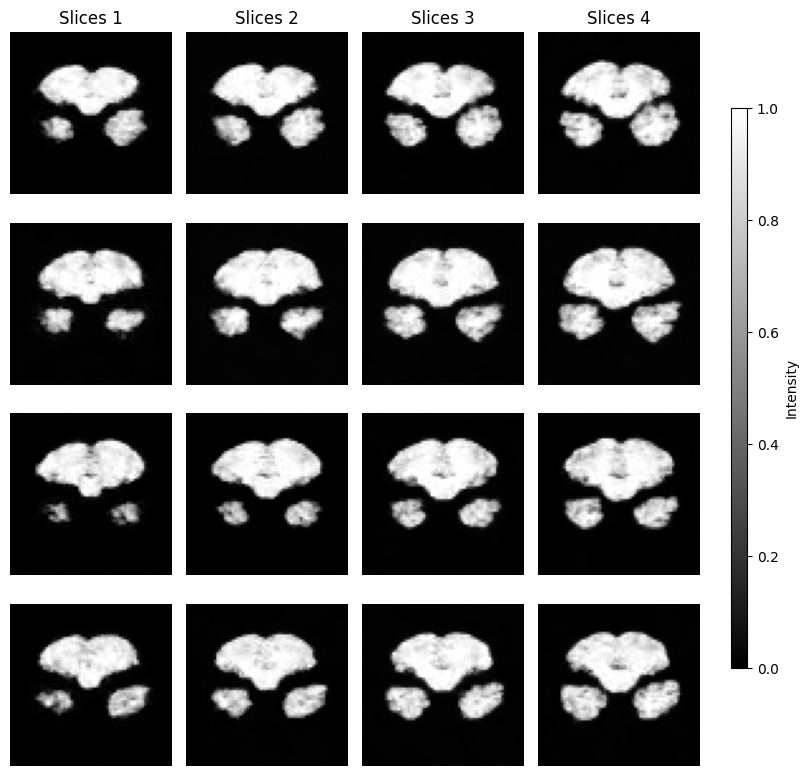

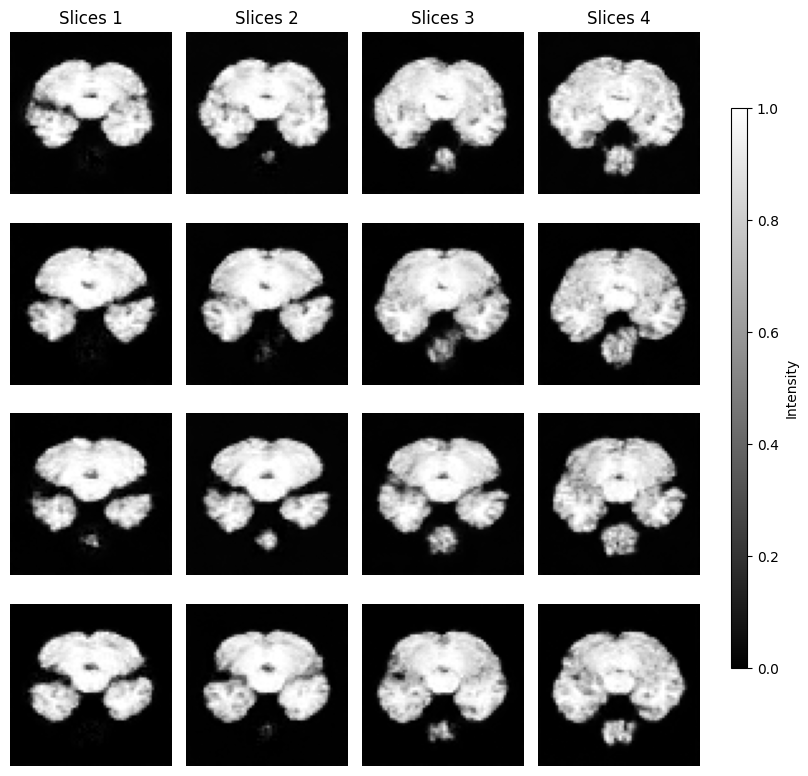

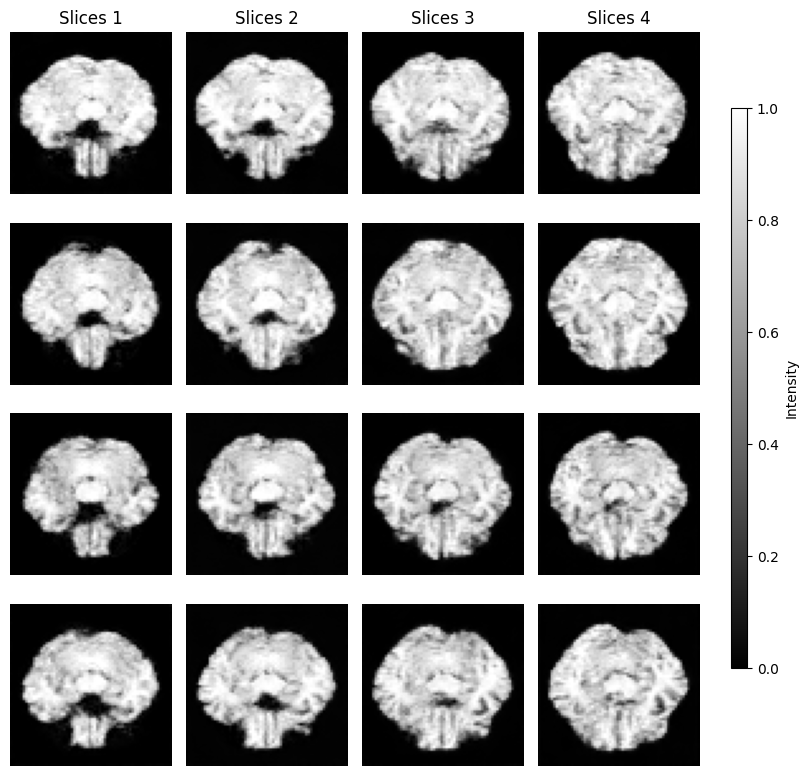

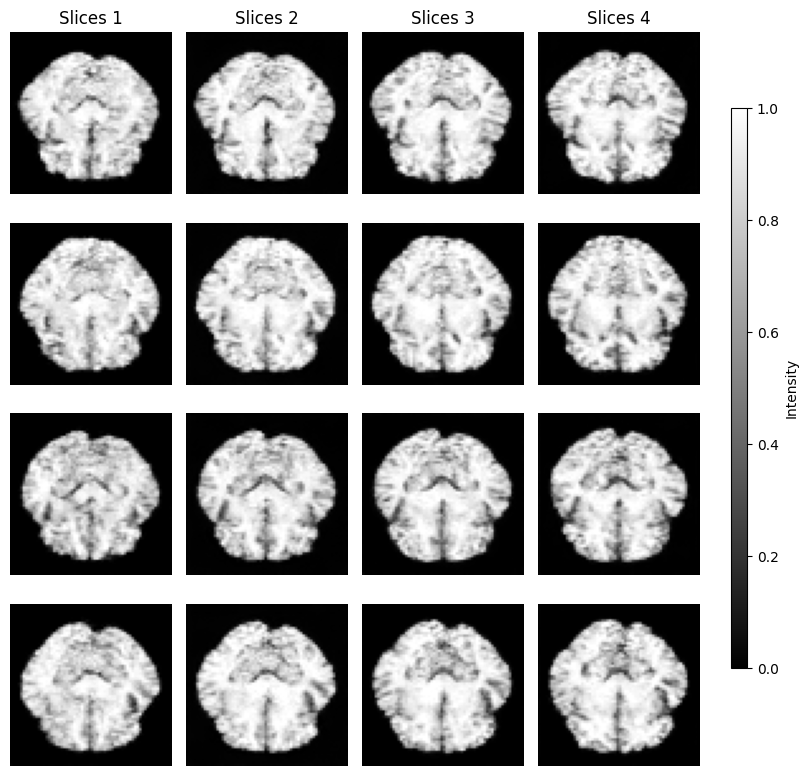

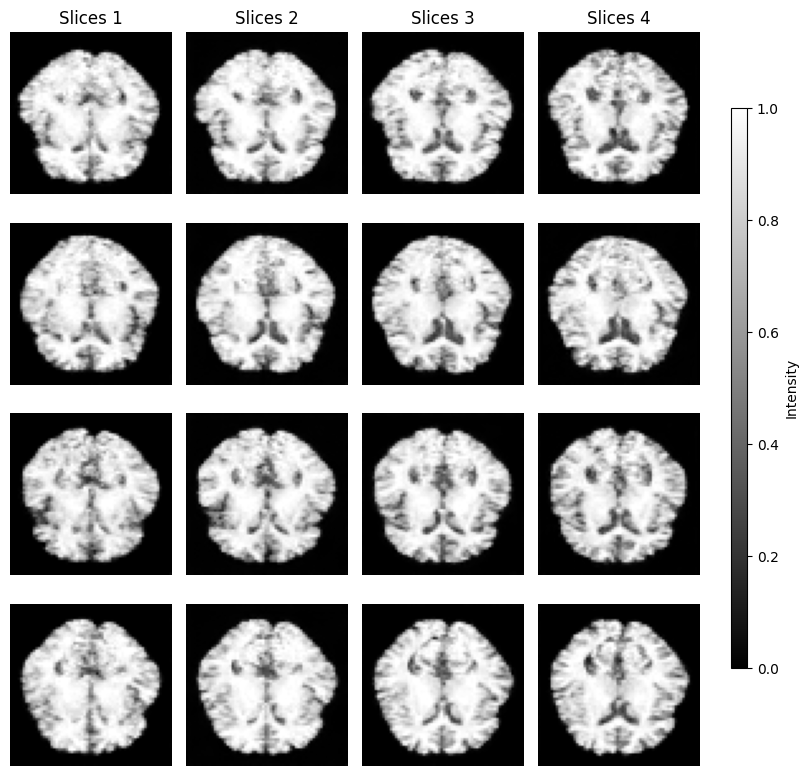

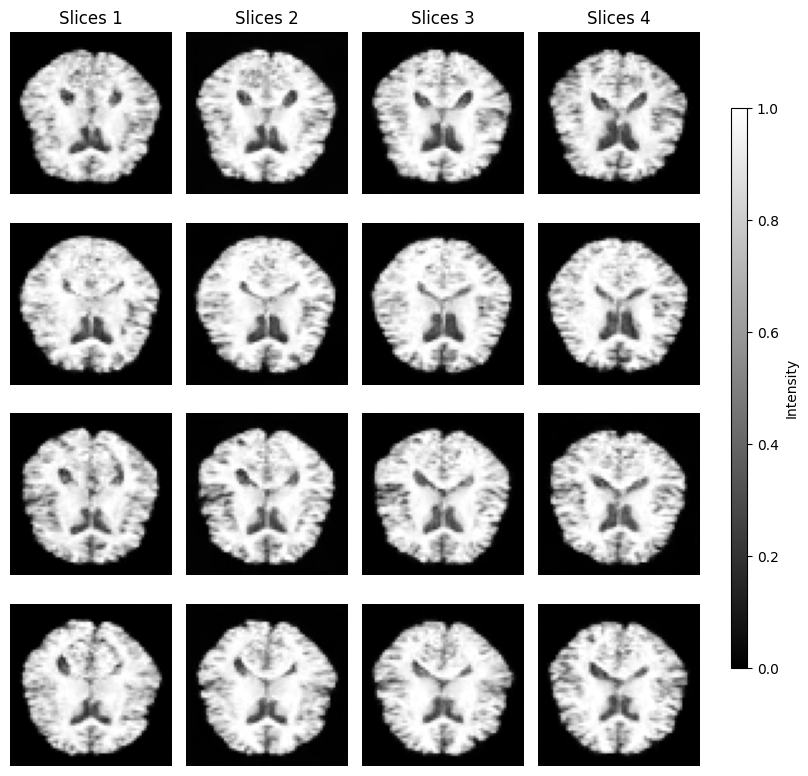

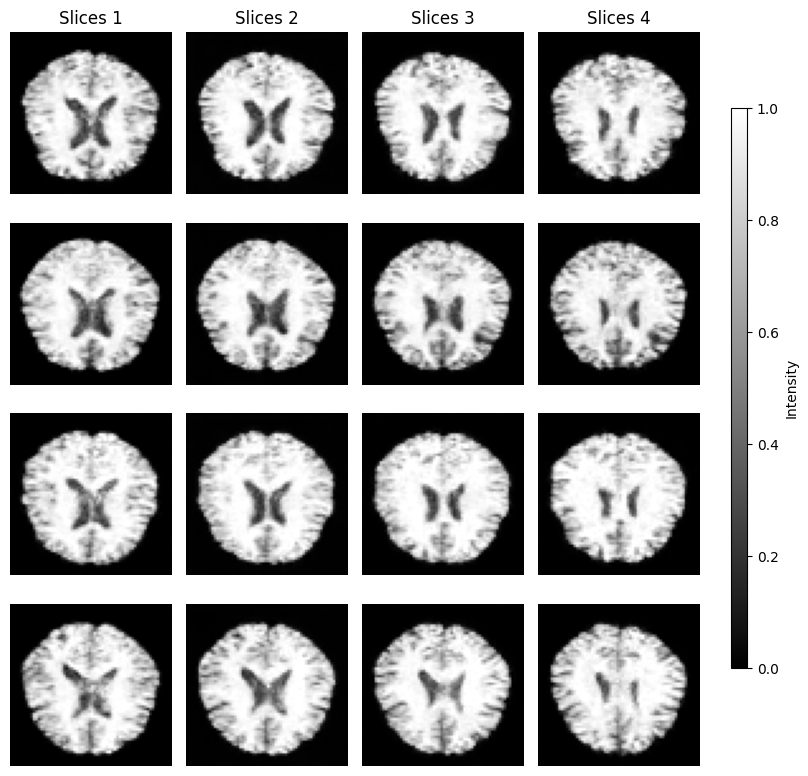

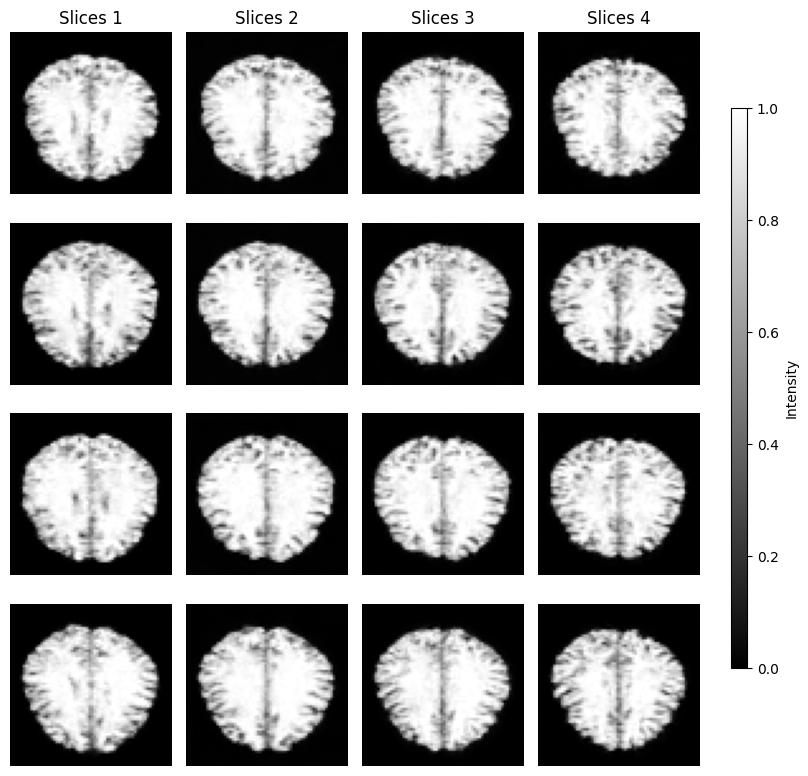

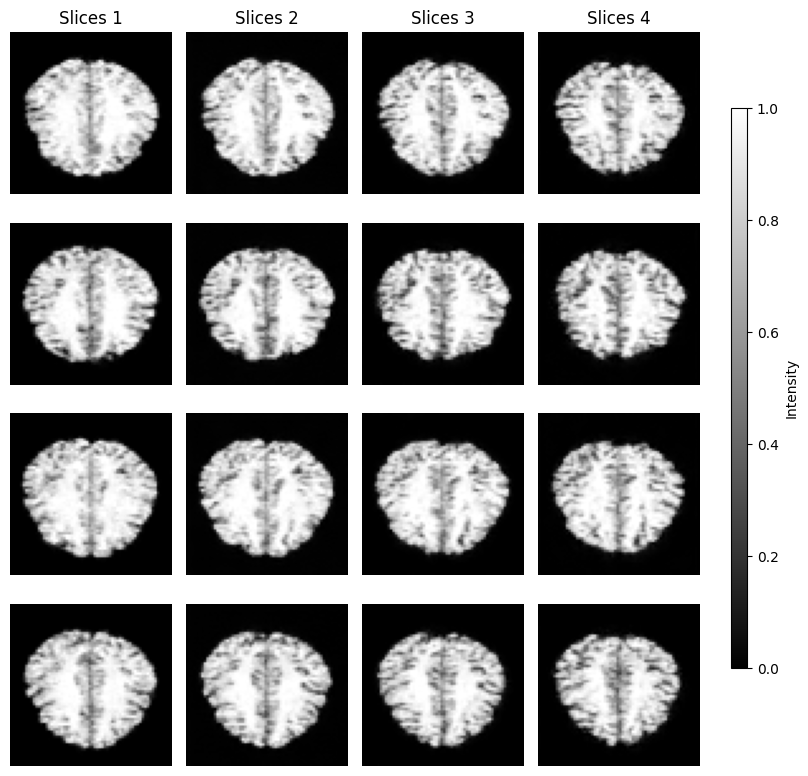

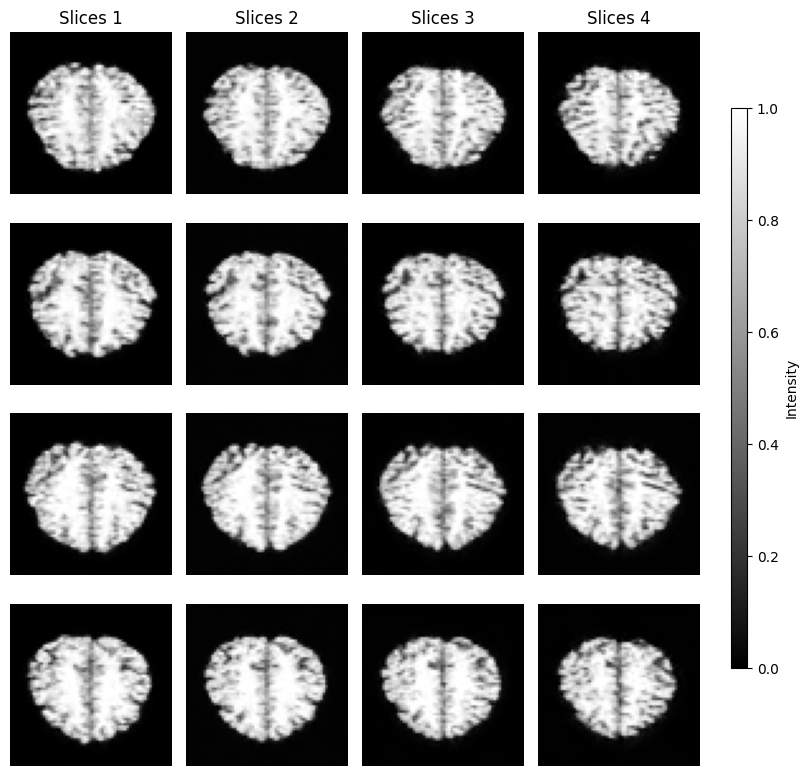

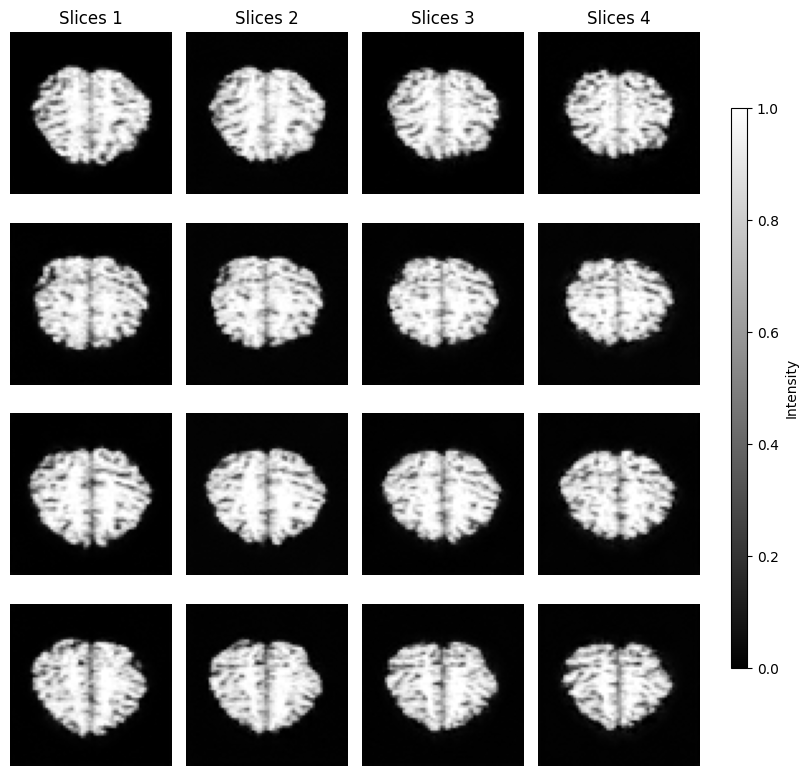

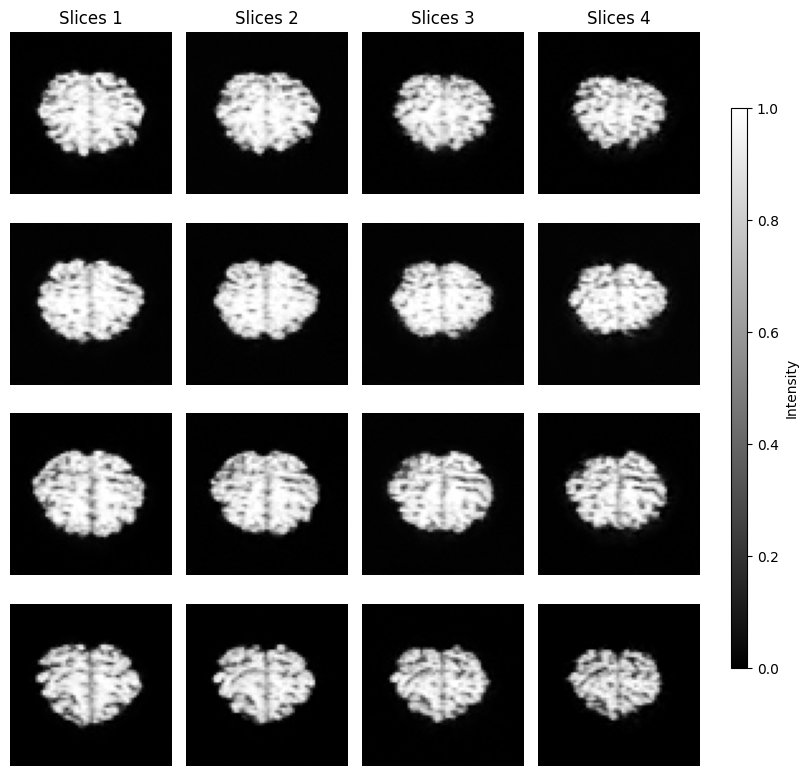

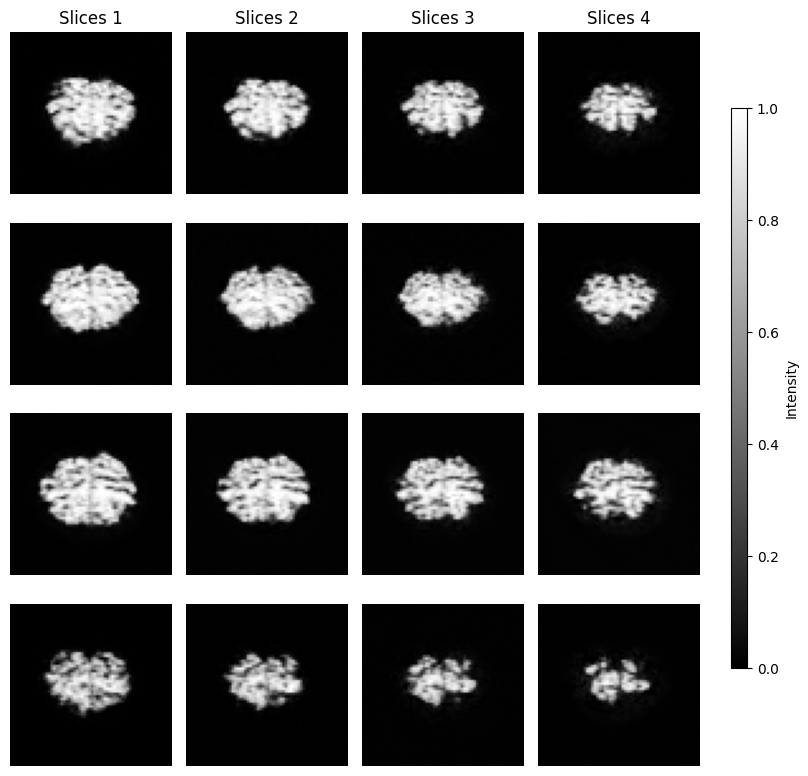

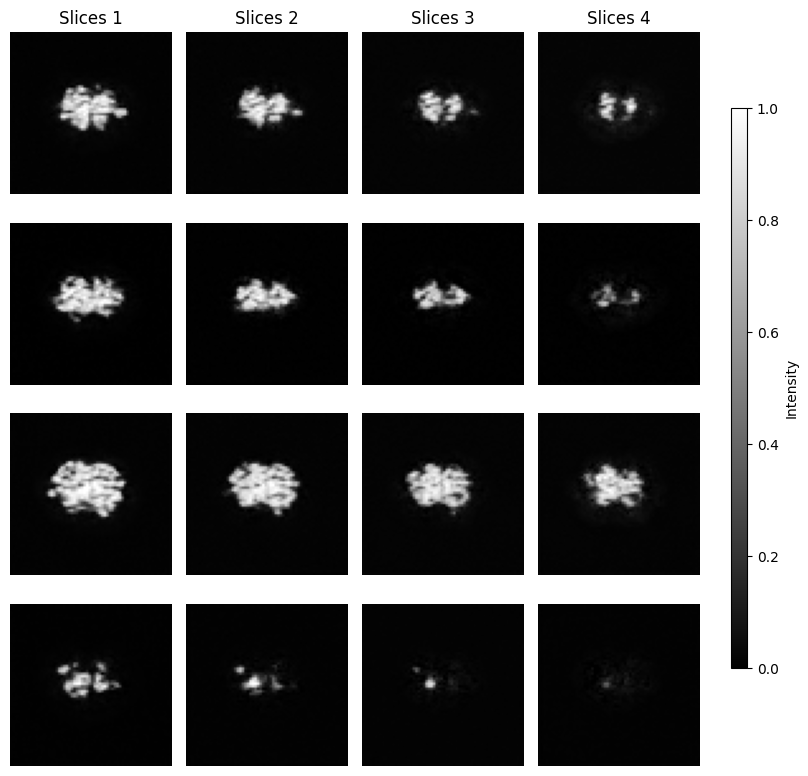

In [28]:
output_batch = sample_iteratively(condition_start_index, slices_at_once, None, model, noise_scheduler, None, batch_size, device, symmetric_normalisation=symmetric_normalisation, index_encoding_type='index_normalised', verbose=True, data_size=data_size, save_path=save_plots_dir)

In [29]:
data_dir = "/cim/ehoney/ecse626proj/preprocessed_data_64"
train_dataset = ADNIDatasetSlicesInOrder(data_dir, sample_full_brain=True, symmetric_normalisation=symmetric_normalisation, data_size=data_size)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8) # CHANGE to NUM_WORKERS=4
one_batch = next(iter(train_dataloader))

In [30]:
one_batch.shape

torch.Size([4, 64, 64, 64])

In [31]:
save_plots_dir = os.path.join(out_dir,f'sampled_ground_truth')
os.makedirs(save_plots_dir, exist_ok=True)

Plotting slices from slice 0 to 4...


/cim/ehoney/ecse626proj/common/utils.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar


Plotting slices from slice 4 to 8...
Plotting slices from slice 8 to 12...
Plotting slices from slice 12 to 16...
Plotting slices from slice 16 to 20...
Plotting slices from slice 20 to 24...
Plotting slices from slice 24 to 28...
Plotting slices from slice 28 to 32...
Plotting slices from slice 32 to 36...
Plotting slices from slice 36 to 40...
Plotting slices from slice 40 to 44...
Plotting slices from slice 44 to 48...
Plotting slices from slice 48 to 52...
Plotting slices from slice 52 to 56...
Plotting slices from slice 56 to 60...
Plotting slices from slice 60 to 64...


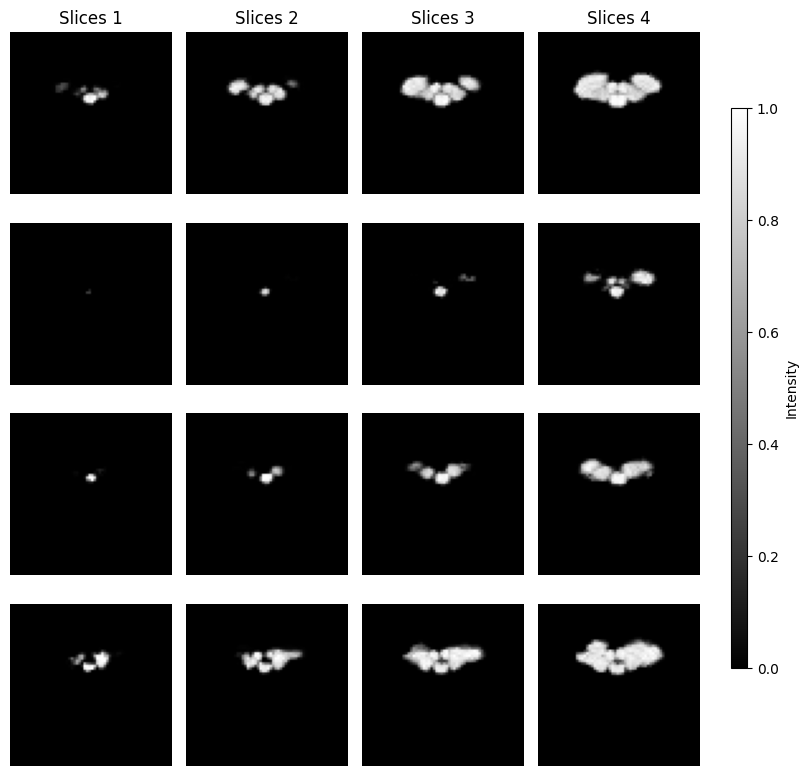

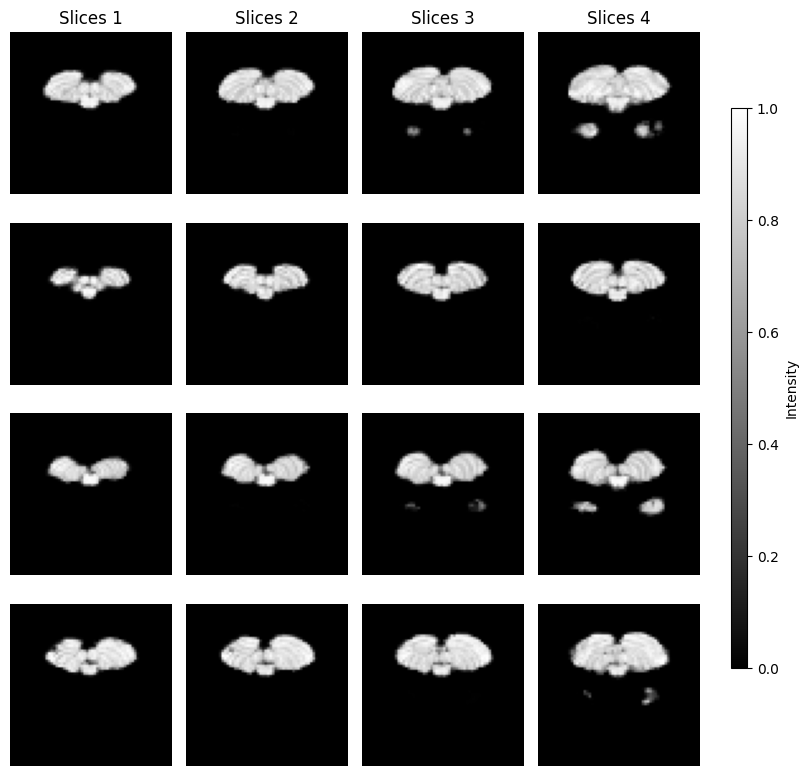

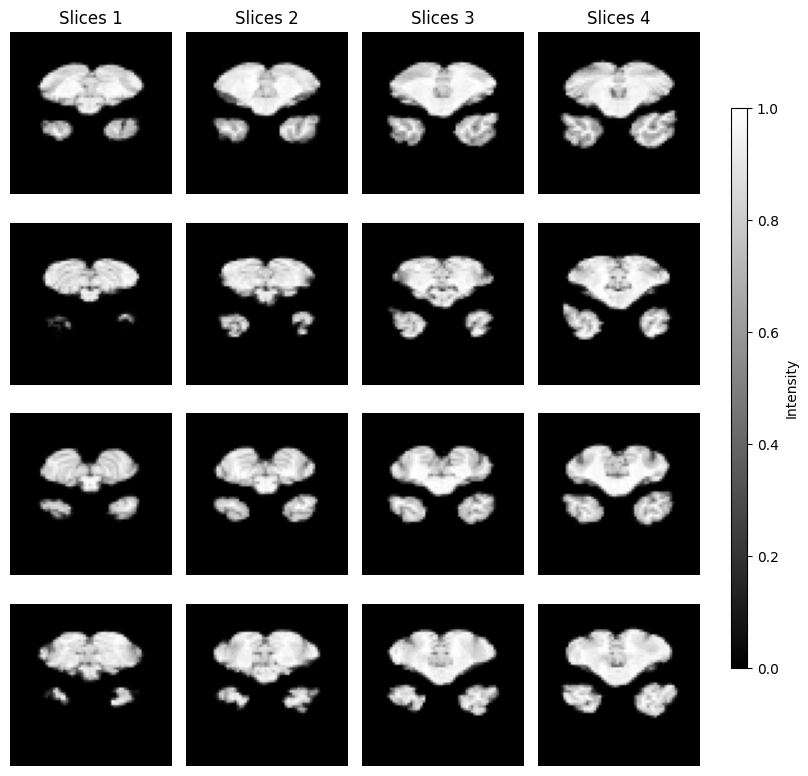

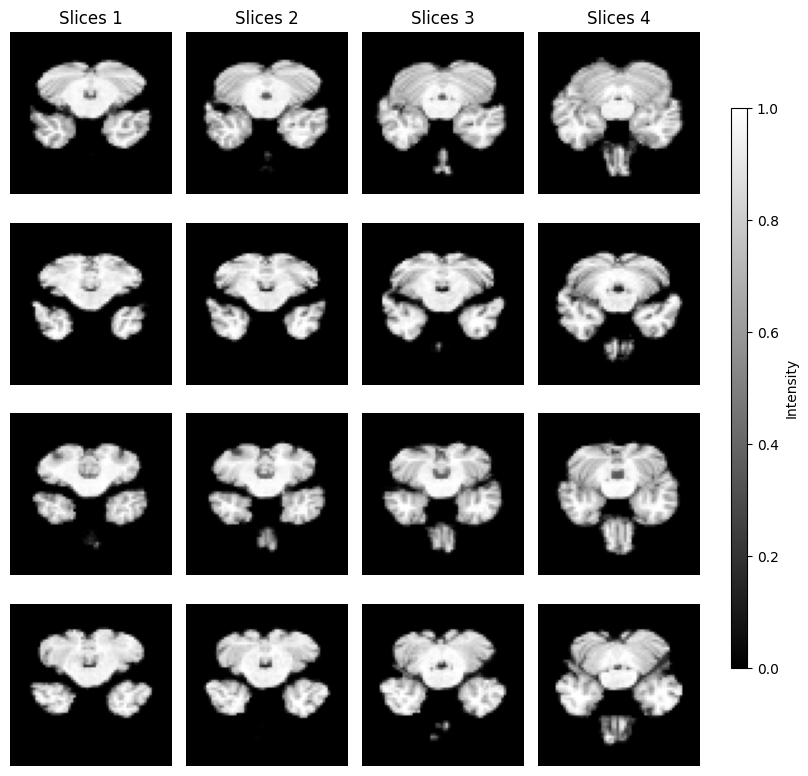

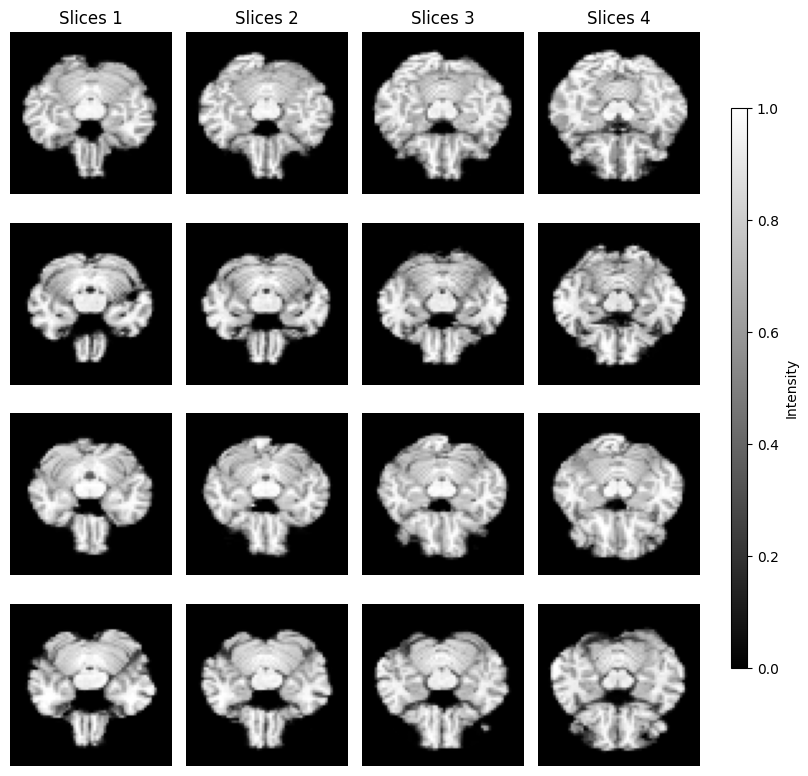

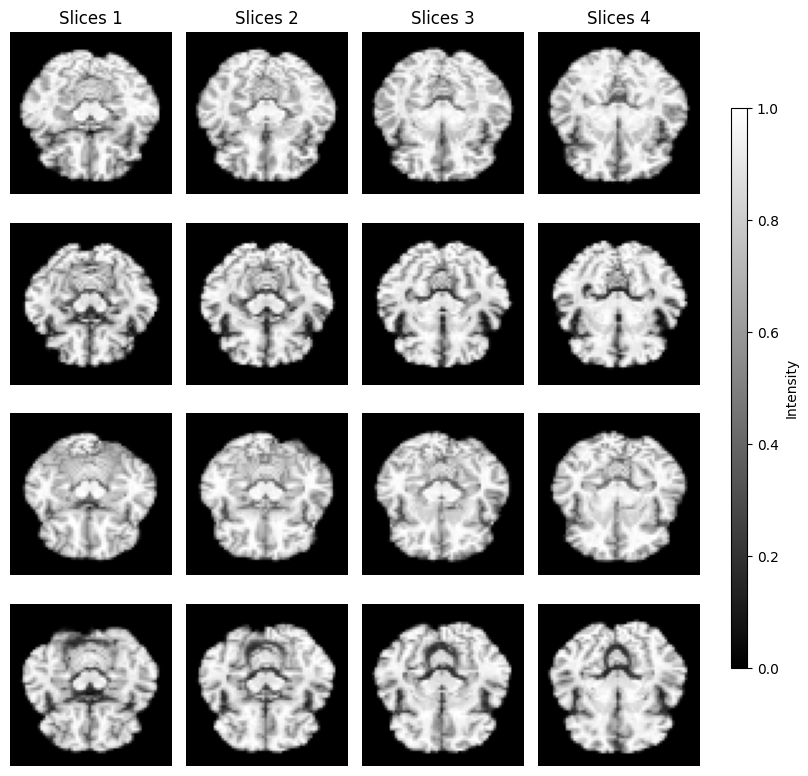

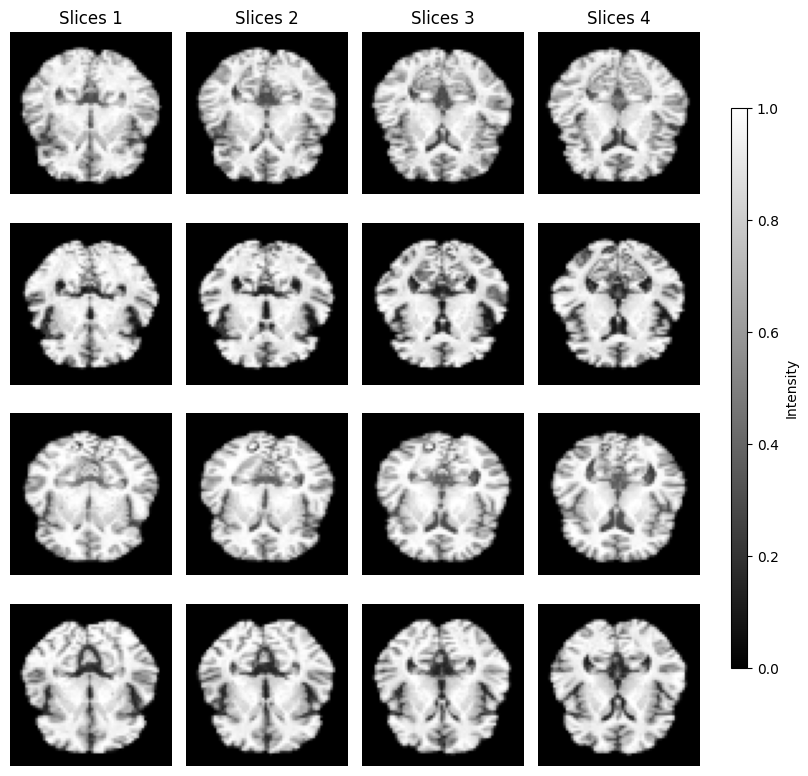

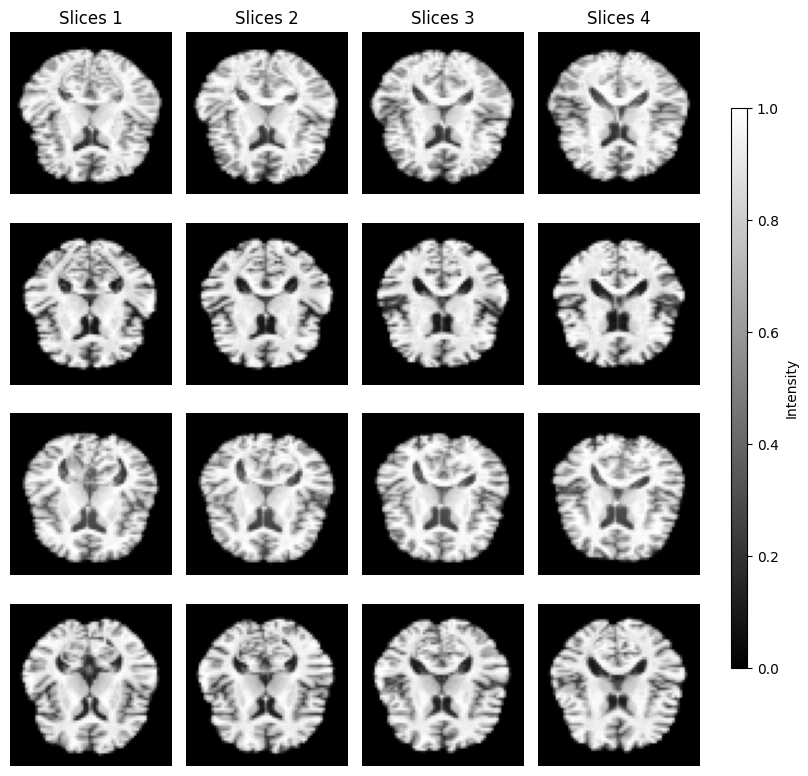

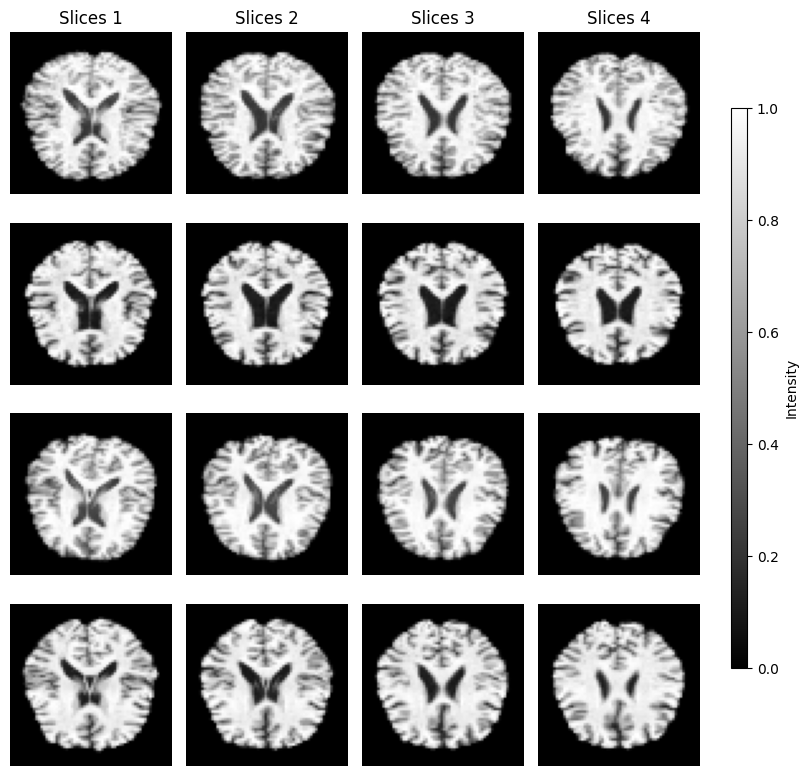

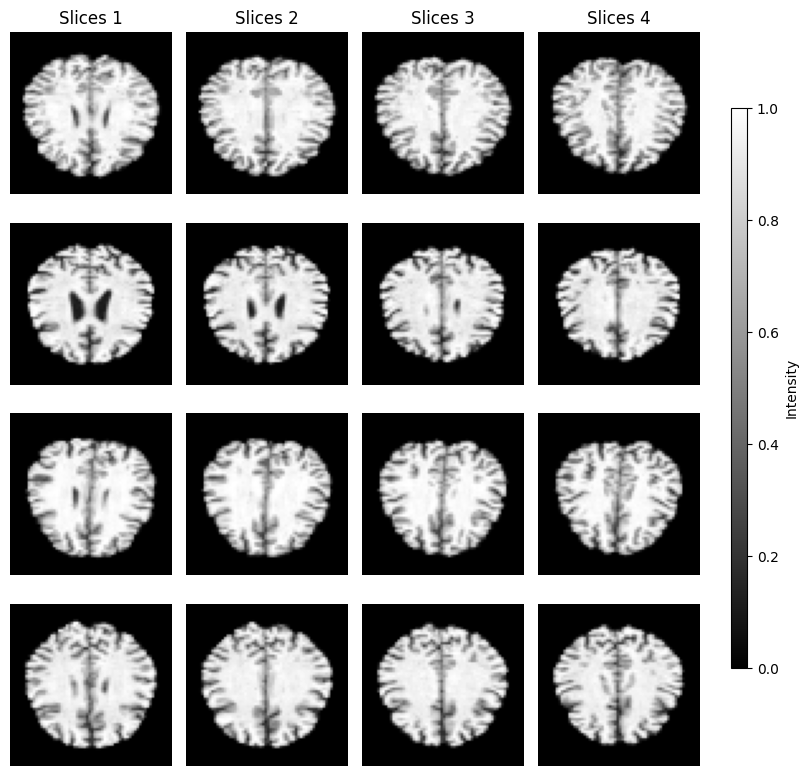

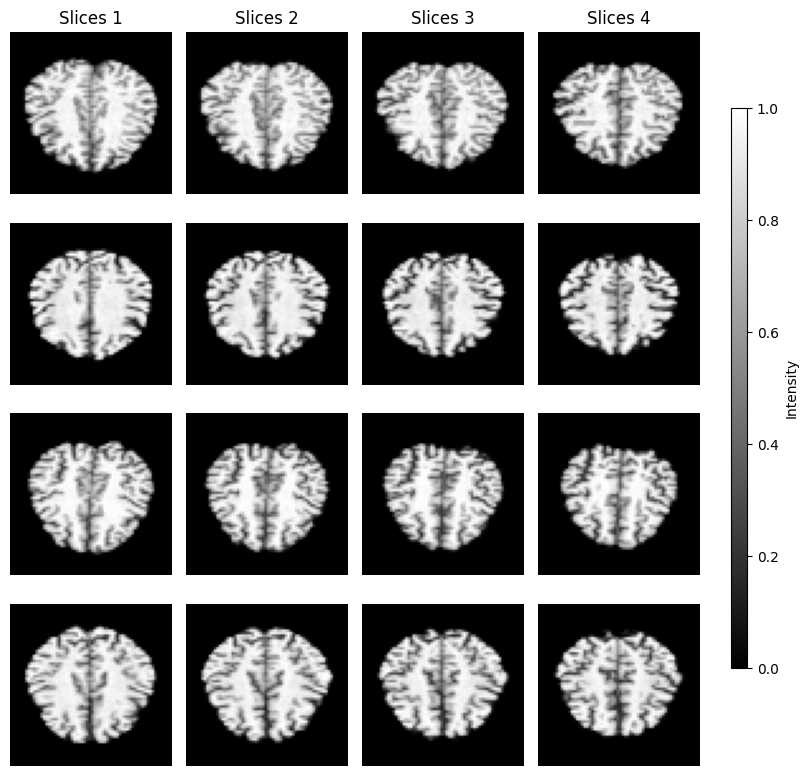

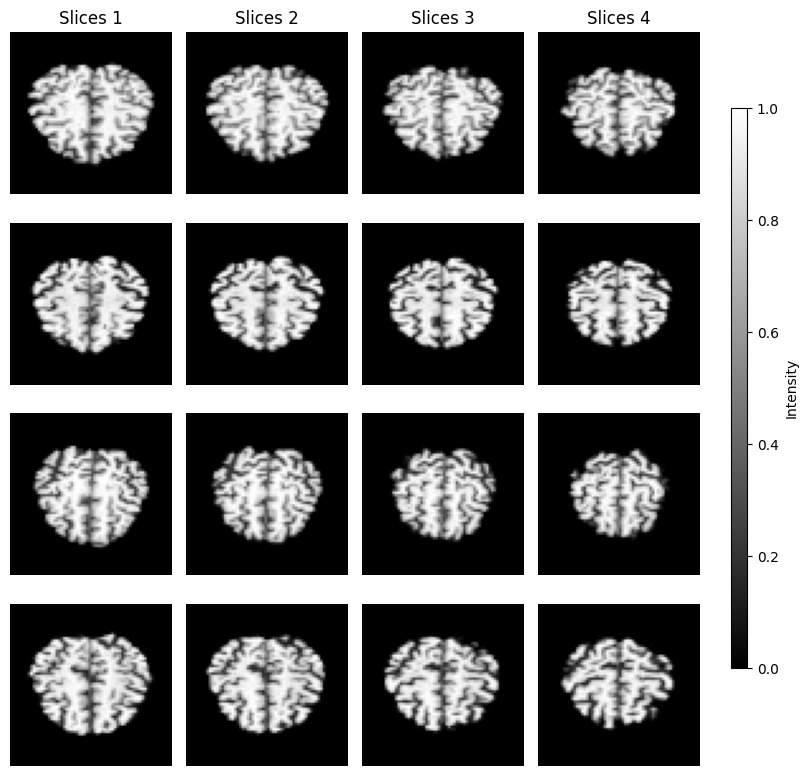

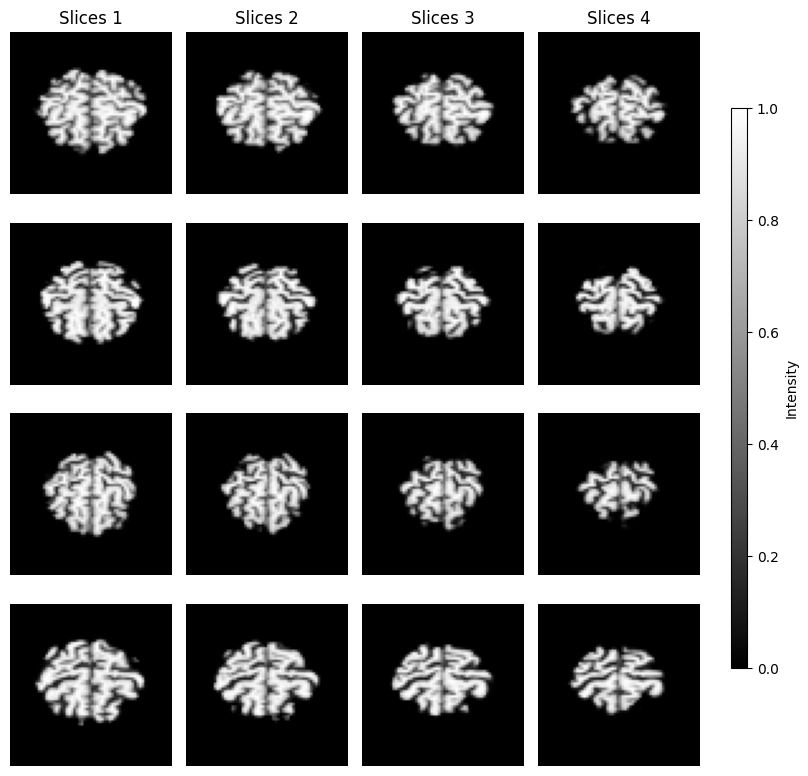

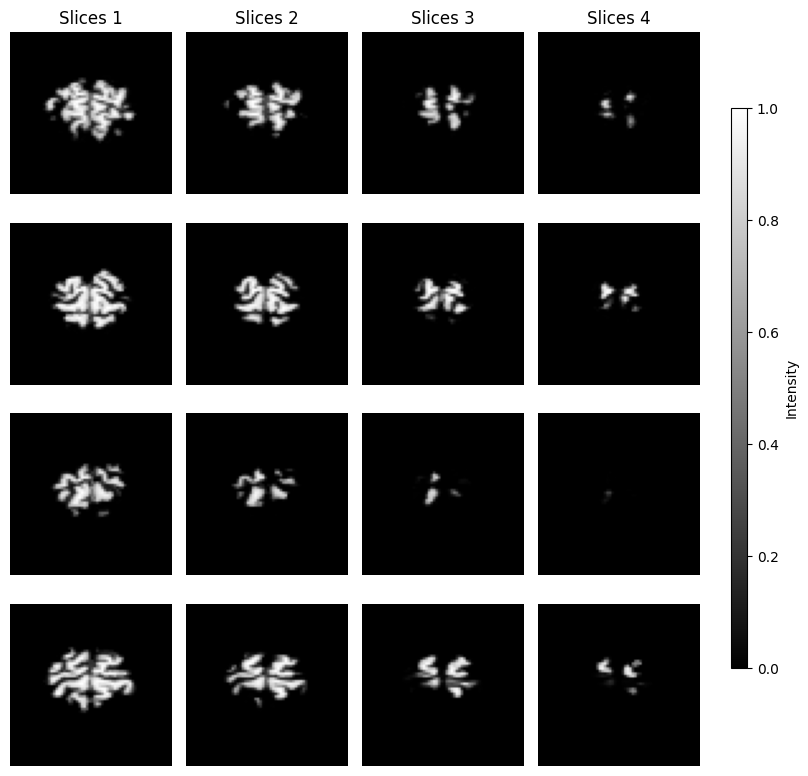

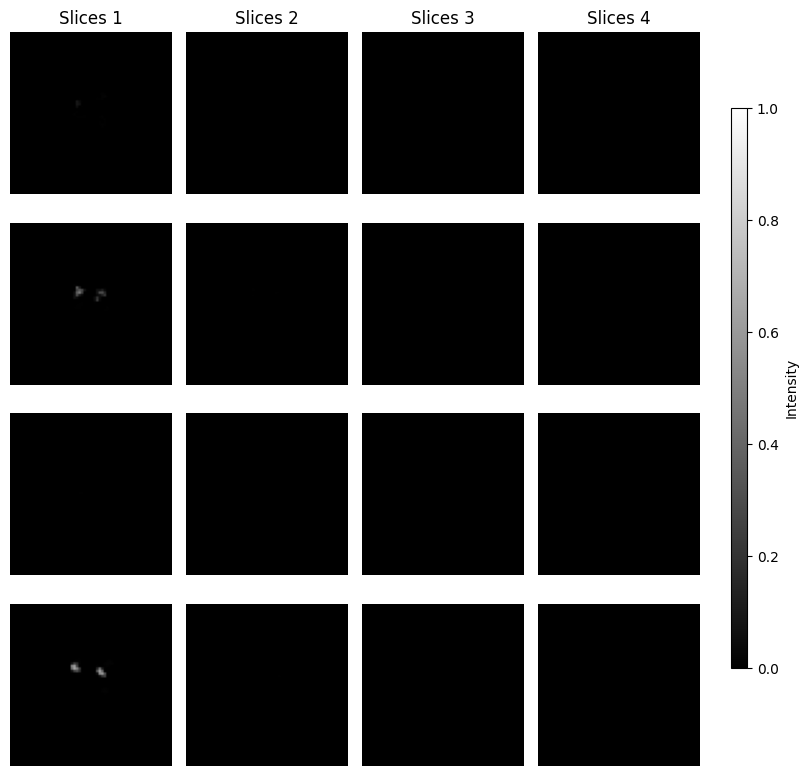

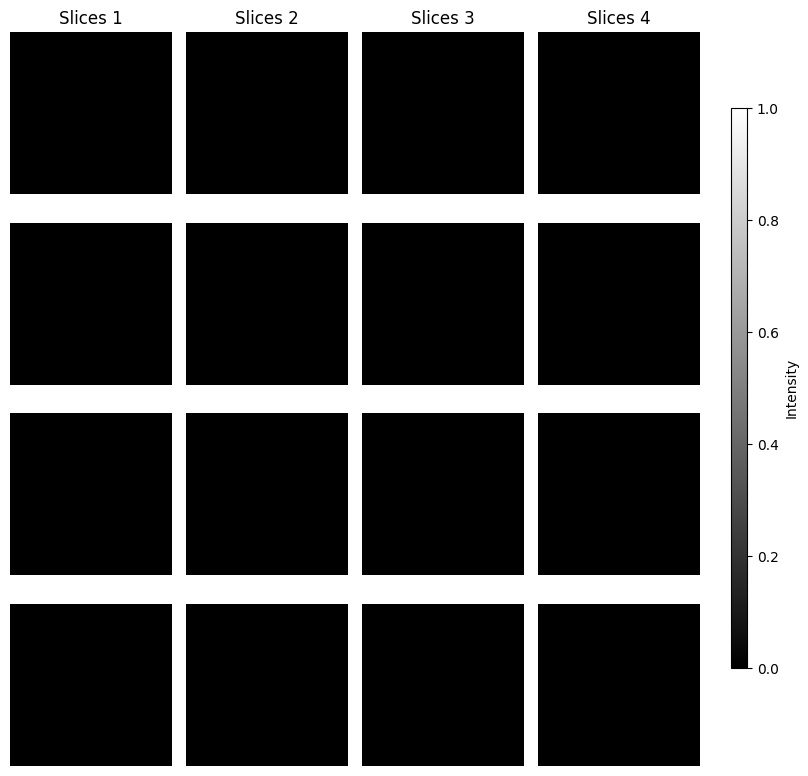

In [33]:
for i in range(0, data_size, slices_at_once):
    print(f'Plotting slices from slice {i} to {i+slices_at_once}...')
    condition_slices = one_batch[:, i:i+slices_at_once].float().to(device)
    plot_batch_slices(condition_slices, batch_size, slices=slices_at_once, vmin=vmin, save_path=os.path.join(save_plots_dir, f'{i}_to_{i+slices_at_once}'))

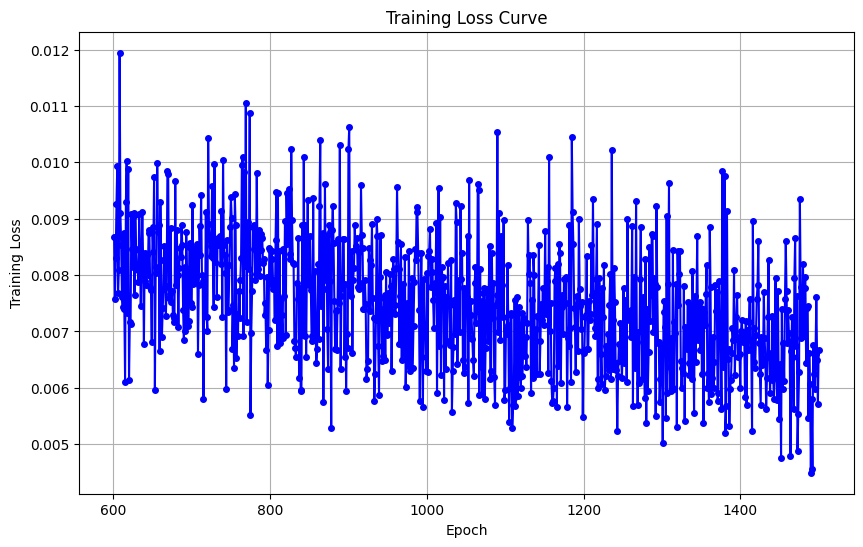

In [14]:
import pandas as pd

# Make sure to provide the correct path to your CSV file
csv_file = os.path.join(out_dir, 'train_loss.csv')  # Replace with your actual file path
data = pd.read_csv(csv_file)

start=600

# Plotting the training loss curve
plt.figure(figsize=(10, 6))
plt.plot(data['Epoch'][start:], data['Training Loss'][start:], marker='o', color='b', linestyle='-', markersize=4)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.grid(True)
plt.show()

In [ ]:
# best_loss_ckpt = torch.load('best_loss_ckpt.pth.tar')
# best_loss_ckpt = torch.load('best_loss_ckpt_below1000.pth.tar')

/tmp/ipykernel_3793266/2822479757.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_loss_ckpt = torch.load('best_loss_ckpt.pth.tar')


In [12]:
# torch.save(best_loss_ckpt, 'best_loss_ckpt_below1000.pth.tar')
# torch.save(best_loss_ckpt, 'best_loss_ckpt_below1500.pth.tar')

In [16]:
best_loss_ckpt['loss']

0.004493635

Epoch 878 - best loss by 1000 epochs

Epoch 1490 - best loss by 1500 epochs